# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.AR
using LAR.DataAR

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file1 = "../data/obama.wav"   # specify sound location
sound_file2 = "../data/drilling.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 32                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 5
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 5
iterations = 3

# load model parameters
load_file1 = "../inferred_values/all_speech_AR05_05freqs.h5" # file in which model parameters are present
load_file2 = "../inferred_values/all_drilling_AR05_05freqs.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time1, fs_time1 = wavread(sound_file1, format="native")
fs_time1 = Int(fs_time1)
x_time1 = x_time1[24*fs_time1+1:27*fs_time1]
x_time1 = resample(x_time1, fs_desired/fs_time1)
x_time1 = 100*x_time1/var(x_time1)

# load and process speech signal
x_time2, fs_time2 = wavread(sound_file2, format="native")
fs_time2 = Int(fs_time2)
x_time2 = x_time2[24*fs_time2+1:27*fs_time2]
x_time2 = resample(x_time2, fs_desired/fs_time2)
x_time2 = 100*x_time2/var(x_time2)

x_tot = x_time1 + x_time2

# specify time axis
t = collect((1:length(x_time1))/fs_desired)

# create audioplayer
audioplayers(x_time1, x_time2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

In [4]:
# placeholder for parameters
params1 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)
params2 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)

# load parameters
for k = 1:2*freq_bins
    # load parameters of imaginary coefficients
    params1[k] = h5read(load_file1, "bin_"*string(k, pad=2))     
    params2[k] = h5read(load_file2, "bin_"*string(k, pad=2))     
end
;

## Visualize data

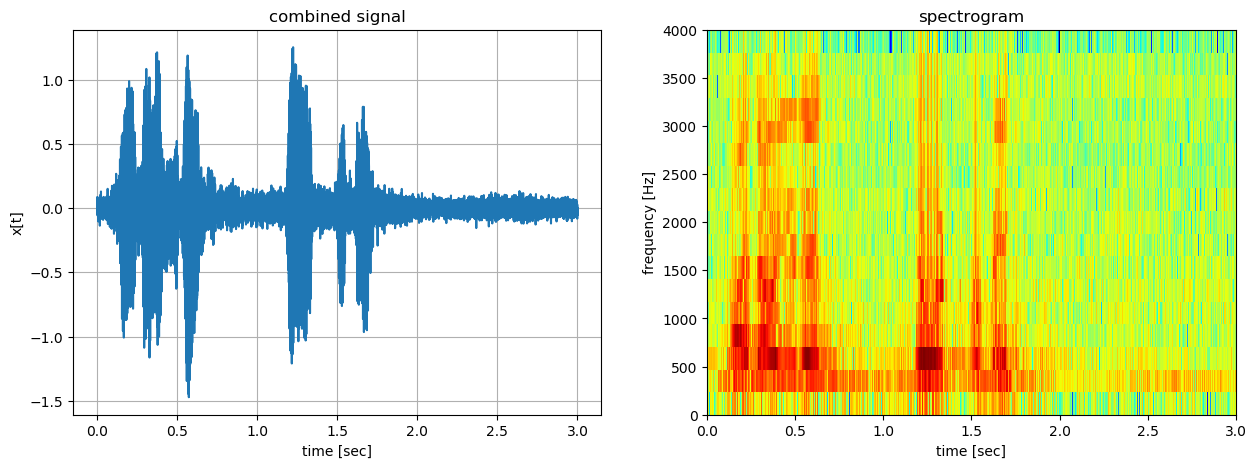

In [5]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("combined signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [6]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min1 = Array{Variable,1}(undef, 2*length(freq))
γ1 = Array{Variable,1}(undef, 2*length(freq))
θ1 = Array{Variable,1}(undef, 2*length(freq))
z1 = Array{Variable,1}(undef, 2*length(freq))

# placeholders
z_min2 = Array{Variable,1}(undef, 2*length(freq))
γ2 = Array{Variable,1}(undef, 2*length(freq))
θ2 = Array{Variable,1}(undef, 2*length(freq))
z2 = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min1,k)] z_min1[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min1, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min1, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ1,k)] γ1[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ1,k)), placeholder(pad(:b_γ1,k)))
    @RV [id=pad(:θ1,k)] θ1[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ1,k), dims=(AR_order,)), placeholder(pad(:Σ_θ1,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z1,k)] z1[k] ~ LAR.AR.Autoregressive(θ1[k], z_min1[k], γ1[k])
end

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min2,k)] z_min2[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min2, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min2, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ2,k)] γ2[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ2,k)), placeholder(pad(:b_γ2,k)))
    @RV [id=pad(:θ2,k)] θ2[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ2,k), dims=(AR_order,)), placeholder(pad(:Σ_θ2,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z2,k)] z2[k] ~ LAR.AR.Autoregressive(θ2[k], z_min2[k], γ2[k])
end

# specify Fourier matrix
Ceme11 = Array{Variable,1}(undef, 2*length(freq))
Ceme12 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme11[k] 
    placeholder(Ceme11[k], pad(:Ceme11,k), dims = (buffer_size, AR_order))
    @RV Ceme12[k] 
    placeholder(Ceme12[k], pad(:Ceme12,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x1 = sum(Ceme11.*z1)
@RV x2 = sum(Ceme12.*z2)
@RV y = x1 + x2 + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3175952080789871715 -->
 3175952080789871715 
 
 𝒩 
 gaussianmeanvariance_40 
 
<!-- 13424956727096979782 -->
 13424956727096979782 
 
 placeholder_μ_z_min2_10 
 
<!-- 3175952080789871715--13424956727096979782 -->
 3175952080789871715--13424956727096979782 
 
 μ_z_min2_10 
 1 out 
 2 m 
 
<!-- 11456221359965109049 -->
 11456221359965109049 
 
 placeholder_Σ_z_min2_10 
 
<!-- 3175952080789871715--11456221359965109049 -->
 3175952080789871715--11456221359965109049 
 
 Σ_z_min2_10 
 1 out 
 3 v 
 
<!-- 12992550820542029995 -->
 12992550820542029995 
 
 𝒩 
 gaussianmeanvariance_11 
 
<!-- 14542818450711569799 -->
 14542818450711569799 
 
 placeholder_μ_θ1_05 
 
<!-- 12992550820542029995--14542818450711569799 -->
 12992550820542029995--14542818450711569799 
 
 μ_θ1_05 
 1 out 
 2 m 
 
<!-- 6636315150854250180 -->
 6636315150854250180 
 
 placeholder_Σ_θ1_05 
 
<!-- 12992550820542029995--6636315150854250180 -->
 12992550820542029995--6636315150854250180 
 
 Σ_θ1_05 
 1 out 
 3 v 
 
<!-- 8751922907574968027 -->
 8751922907574968027 
 
 placeholder_Ceme11_2 
 
<!-- 8969544539063822368 -->
 8969544539063822368 
 
 placeholder_b_γ2_10 
 
<!-- 1872093033927042825 -->
 1872093033927042825 
 
 placeholder_Σ_z_min1_01 
 
<!-- 16758953920005595954 -->
 16758953920005595954 
 
 𝒩 
 gaussianmeanvariance_12 
 
<!-- 11920427681170034070 -->
 11920427681170034070 
 
 placeholder_Σ_z_min1_06 
 
<!-- 16758953920005595954--11920427681170034070 -->
 16758953920005595954--11920427681170034070 
 
 Σ_z_min1_06 
 1 out 
 3 v 
 
<!-- 3642966496711339117 -->
 3642966496711339117 
 
 placeholder_μ_z_min1_06 
 
<!-- 16758953920005595954--3642966496711339117 -->
 16758953920005595954--3642966496711339117 
 
 μ_z_min1_06 
 1 out 
 2 m 
 
<!-- 16098962620494192608 -->
 16098962620494192608 
 
 Gam 
 gamma_2 
 
<!-- 1087189548975377238 -->
 1087189548975377238 
 
 placeholder_a_γ1_02 
 
<!-- 16098962620494192608--1087189548975377238 -->
 16098962620494192608--1087189548975377238 
 
 a_γ1_02 
 1 out 
 2 a 
 
<!-- 8899750725635633255 -->
 8899750725635633255 
 
 placeholder_b_γ1_02 
 
<!-- 16098962620494192608--8899750725635633255 -->
 16098962620494192608--8899750725635633255 
 
 b_γ1_02 
 1 out 
 3 b 
 
<!-- 14467127297070387291 -->
 14467127297070387291 
 
 placeholder_Ceme11_9 
 
<!-- 7898597520653967777 -->
 7898597520653967777 
 
 placeholder_μ_z_min2_03 
 
<!-- 15637959735025507547 -->
 15637959735025507547 
 
 placeholder_Σ_z_min1_05 
 
<!-- 12669154450301307805 -->
 12669154450301307805 
 
 placeholder_a_γ2_05 
 
<!-- 14523387741612908198 -->
 14523387741612908198 
 
 AR 
 autoregressive_18 
 
<!-- 8301098547032723175 -->
 8301098547032723175 
 
 𝒩 
 gaussianmeanvariance_37 
 
<!-- 14523387741612908198--8301098547032723175 -->
 14523387741612908198--8301098547032723175 
 
 θ2_08 
 1 out 
 3 θ 
 
<!-- 17728352614951560478 -->
 17728352614951560478 
 
 Gam 
 gamma_18 
 
<!-- 14523387741612908198--17728352614951560478 -->
 14523387741612908198--17728352614951560478 
 
 γ2_08 
 1 out 
 4 γ 
 
<!-- 1490040628058930558 -->
 1490040628058930558 
 
 𝒩 
 gaussianmeanvariance_36 
 
<!-- 14523387741612908198--1490040628058930558 -->
 14523387741612908198--1490040628058930558 
 
 z_min2_08 
 1 out 
 2 x 
 
<!-- 12728775118303109598 -->
 12728775118303109598 
 
 placeholder_Σ_z_min2_06 
 
<!-- 16353512312037998505 -->
 16353512312037998505 
 
 Gam 
 gamma_12 
 
<!-- 6688451288570920809 -->
 6688451288570920809 
 
 placeholder_b_γ2_02 
 
<!-- 16353512312037998505--6688451288570920809 -->
 16

In [7]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ1, z1, z_min1, γ1, θ2, z2, z_min2, γ2, x1, x2, ids=[:θ1 :z1 :z_min1 :γ1 :θ2 :z2 :z_min2 :γ2 :x1 :x2])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [8]:
println(algo)

begin

function stepz_min2!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 20))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_10]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_10]))
messages[2] = ruleVariationalARIn1PNPP(marginals[:z2_10], nothing, marginals[:θ2_10], marginals[:γ2_10])
messages[3] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_09]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_09]))
messages[4] = ruleVariationalARIn1PNPP(marginals[:z2_09], nothing, marginals[:θ2_09], marginals[:γ2_09])
messages[5] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_08]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_08]))
messages[6] = ruleVariationalARIn1PNPP(marginals

## Perform inference

In [9]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min1 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min1 = Array{Array{Float64,2},1}(undef, 2*length(freq))
μ_z_min2 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min2 = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min1[k] = zeros(AR_order)
    Σ_z_min1[k] = 1e-2*Ic(AR_order)    
    μ_z_min2[k] = zeros(AR_order)
    Σ_z_min2[k] = 1e-2*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ1, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params1[k]["a_gamma"], b=params1[k]["b_gamma"])
    marginals[pad(:θ1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params1[k]["mean_theta"], v=params1[k]["cov_theta"])
    marginals[pad(:z_min1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min1[k], v=Σ_z_min1[k])
    marginals[pad(:γ2, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params2[k]["a_gamma"], b=params2[k]["b_gamma"])
    marginals[pad(:θ2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params2[k]["mean_theta"], v=params2[k]["cov_theta"])
    marginals[pad(:z_min2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min2[k], v=Σ_z_min2[k])
end

# initialize buffer
buf = BufferData(x_tot, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x1 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Σ_x1 = Array{Array{Float64,2},1}(undef, len(buf, step_size))
μ_x2 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Σ_x2 = Array{Array{Float64,2},1}(undef, len(buf, step_size))

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme11,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:Ceme12,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
    end
    
    # infer parameters
    for it = 1:iterations
        
        # update data
        for f = 1:2*length(freq)
            data[pad(:a_γ1, f)] = params1[f]["a_gamma"]
            data[pad(:b_γ1, f)] = params1[f]["b_gamma"]
            data[pad(:μ_θ1, f)] = params1[f]["mean_theta"]
            data[pad(:Σ_θ1, f)] = params1[f]["cov_theta"]
            data[pad(:μ_z_min1, f)] = μ_z_min1[f]
            data[pad(:Σ_z_min1, f)] = Σ_z_min1[f]
           
            data[pad(:a_γ2, f)] = params2[f]["a_gamma"]
            data[pad(:b_γ2, f)] = params2[f]["b_gamma"]
            data[pad(:μ_θ2, f)] = params2[f]["mean_theta"]
            data[pad(:Σ_θ2, f)] = params2[f]["cov_theta"]
            data[pad(:μ_z_min2, f)] = μ_z_min2[f]
            data[pad(:Σ_z_min2, f)] = Σ_z_min2[f]
        end
        
        # perform steps 
        marginals = Base.invokelatest(stepx1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepx2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min1!, data, marginals, messages)
        marginals = Base.invokelatest(stepz_min2!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ1!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ2!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ1!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ2!, data, marginals, messages)

        # update hidden states
        for f = 1:2*length(freq)
            μ_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z_min1,f)])
            Σ_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z_min1,f)])            
            μ_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z_min2,f)])
            Σ_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z_min2,f)])
        end
    end
        
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z1,f)])
        Σ_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z1,f)])            
        μ_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z2,f)])
        Σ_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z2,f)])
    end
    
    # fetch predictions
    μ_x1[k] = ForneyLab.unsafeMean(marginals[:x1])
    Σ_x1[k] = ForneyLab.unsafeCov(marginals[:x1])
    μ_x2[k] = ForneyLab.unsafeMean(marginals[:x2])
    Σ_x2[k] = ForneyLab.unsafeCov(marginals[:x2])
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:26:365:44


In [10]:
# convert μ_x to a 1d array
μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

UndefVarError: UndefVarError: μ_x not defined

In [11]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
μ_x_pred_norm = μ_x_pred/maximum(μ_x_pred)
println(var(μ_x_pred))
μ_x_pred_select = μ_x_pred[1:Int(buffer_size/step_size):end]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.55,0.56), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred_select, μ_x_pred_norm, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred not defined

## Performance metrics

In [12]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

UndefVarError: UndefVarError: μ_x_pred_select not defined

In [13]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

UndefVarError: UndefVarError: μ_x_pred_select not defined

In [14]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(μ_x[k][1], Σ_x[k][1,1]), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

UndefVarError: UndefVarError: x_time not defined

In [18]:
μ_x_pred1_first = [μ_x1[k][1] for k = 1:length(μ_x1)]
μ_x_pred2_first = [μ_x2[k][1] for k = 1:length(μ_x2)]
μ_x_pred1_last = [μ_x1[k][end] for k = 1:length(μ_x1)]
μ_x_pred2_last = [μ_x2[k][end] for k = 1:length(μ_x2)]
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

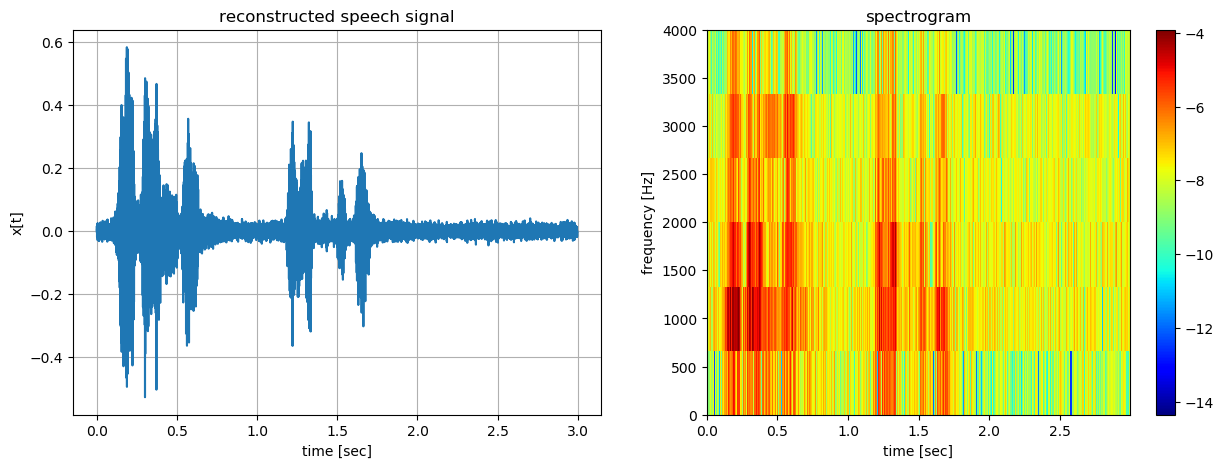

In [39]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(μ_x_pred1_first)], μ_x_pred1_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(μ_x_pred1_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("reconstructed speech signal"), ax[2].set_title("spectrogram")

#plt.plot(μ_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred1_first, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

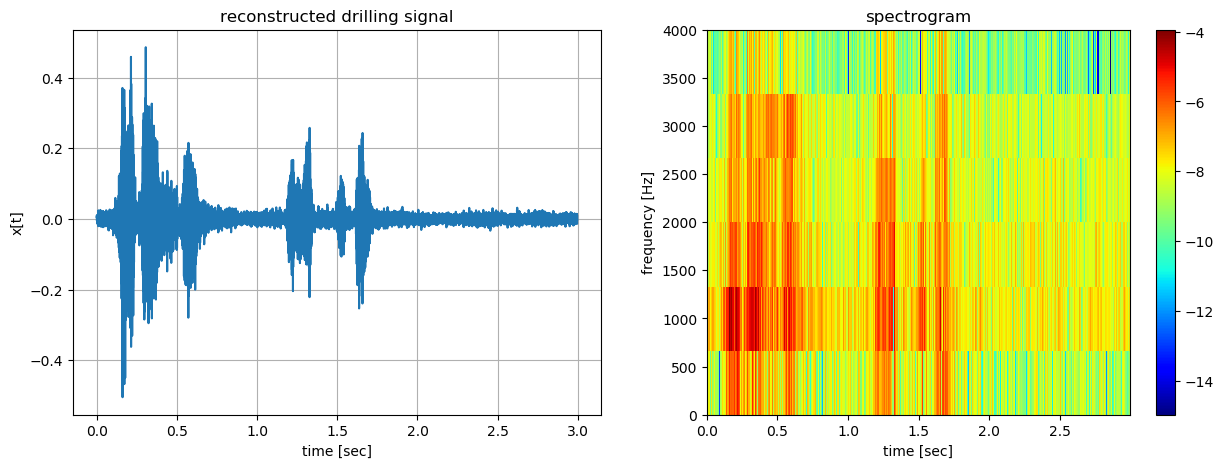

In [40]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(μ_x_pred2_first)], μ_x_pred2_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(μ_x_pred2_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("reconstructed drilling signal"), ax[2].set_title("spectrogram")

#plt.plot(μ_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred2_first, fs=fs_desired)
;

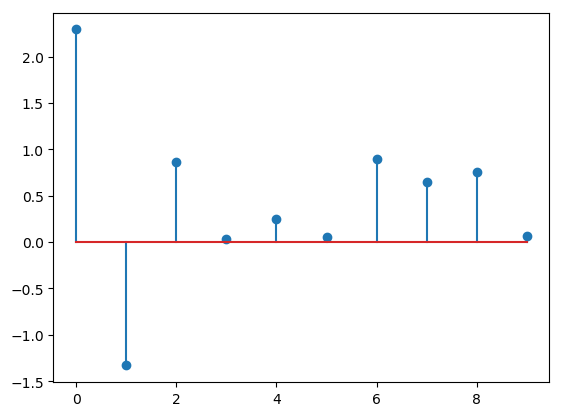

(35952.001000000004, 13259.780309110407, (PyObject <matplotlib.lines.Line2D object at 0x000000002F627D30>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x000000002F62F0B8>, PyObject <matplotlib.lines.Line2D object at 0x000000002F62F240>, PyObject <matplotlib.lines.Line2D object at 0x000000002F62F550>, PyObject <matplotlib.lines.Line2D object at 0x000000002F62F860>, PyObject <matplotlib.lines.Line2D object at 0x000000002F62FB70>, PyObject <matplotlib.lines.Line2D object at 0x000000002F62FE80>, PyObject <matplotlib.lines.Line2D object at 0x000000002F63A1D0>, PyObject <matplotlib.lines.Line2D object at 0x000000002F63A4E0>, PyObject <matplotlib.lines.Line2D object at 0x000000002F63A7F0>, PyObject <matplotlib.lines.Line2D object at 0x000000002F63AB00>], PyObject <matplotlib.lines.Line2D object at 0x000000002F627E48>))

In [57]:
bin = 10
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params1[bin]["a_gamma"]/params1[bin]["b_gamma"]) for bin = 1:2*length(freq)])

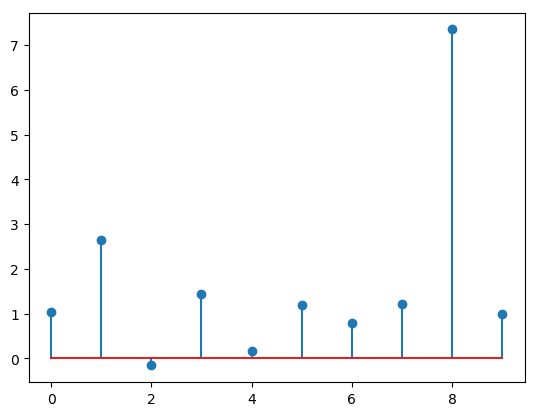

(35952.001000000004, 13259.780309110407, (PyObject <matplotlib.lines.Line2D object at 0x000000002F4E1668>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x000000002F4E19B0>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4E1B38>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4E1E48>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4EB198>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4EB4A8>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4EB7B8>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4EBAC8>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4EBDD8>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4F5128>, PyObject <matplotlib.lines.Line2D object at 0x000000002F4F5438>], PyObject <matplotlib.lines.Line2D object at 0x000000002F4E1780>))

In [58]:
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params2[bin]["a_gamma"]/params2[bin]["b_gamma"]) for bin = 1:2*length(freq)])